# Data loading operations for ProstateX

## Loading the data

Here we will consider each modality (axial T2W and axial DWI) independently since masks are available for both.

In [38]:
import os
from glob import glob
from tqdm import tqdm,trange

from lib.dataoperations.lib.data_functions import *

## Loading and aggregating

### Constructing the path dictionary + gathering median size and spacing

In [41]:
import nibabel as nib
import numpy as np
from itertools import combinations
from lib.utils import *
import SimpleITK as sitk

base_path = "/home/jose_almeida/data/PROSTATEx/ProstateX_resized"
path_dictionary = get_prostatex_path_dictionary(base_path)

size_dict,spacing_dict = get_size_spacing_dict(
    path_dictionary,["DWI","T2WAx"])

for k in size_dict:
    size_dict[k] = np.int32(
        np.median(np.array(size_dict[k]),axis=0))
    spacing_dict[k] = np.median(np.array(spacing_dict[k]),axis=0)

In [42]:
class Round(monai.transforms.MapTransform):
    def __init__(self,keys:List[str],n_digits:int=0)->monai.transforms.MapTransform:
        super().__init__(keys)
        self.keys = keys
        self.n_digits = n_digits

    def __call__(self, data: Mapping[Hashable,TensorOrNDarray]) -> Dict[Hashable,TensorOrNDarray]:
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = d[key]
        return d

    def round_arbitrary(self,x:torch.Tensor)->torch.Tensor:
        if isinstance(x,torch.Tensor):
            return torch.round(x,self.n_digits)
        if isinstance(x,np.ndarray):
            return np.round(x,self.n_digits)

label_path = "/home/jose_almeida/data/PROSTATEx/ProstateX_resized/aggregated-labels-lesion/Prostatex0100_DWI_aggregated.nii.gz"
im_path = "/home/jose_almeida/data/PROSTATEx/ProstateX_resized/DWI/Prostatex0100_CALC_BVAL.nii.gz"

x = im_path
X = nib.load(x)
fdata = X.get_fdata()
affine = X.affine

im = nib.Nifti1Image(fdata,affine)
o = "tmp.nii.gz"
nib.save(im,o)

print("Data type for original:",nib.load(x).get_fdata().dtype)
print("Data type for copy:",nib.load(o).get_fdata().dtype)

S = [2.00,2.00,3.00]

out_1 = monai.transforms.Compose([
    monai.transforms.LoadImaged(['image'])])({'image':x})

out_2 = monai.transforms.Compose([
    monai.transforms.LoadImaged(['image'])])({'image':o})

print(
    "Quantiles of data after LoadImaged:",
    np.quantile(out_1["image"]-out_2["image"],[0,0.05,0.5,0.95,1]))

out_1 = monai.transforms.Compose([
    monai.transforms.LoadImaged(['image']),
    monai.transforms.Spacingd(['image'],S)
])({'image':x})

out_2 = monai.transforms.Compose([
    monai.transforms.LoadImaged(['image']),
    monai.transforms.Spacingd(['image'],S)
])({'image':o})

print(
    "Quantiles of difference after Spacingd:",
    np.quantile(out_1["image"]-out_2["image"],[0,0.05,0.5,0.95,1]))


Data type for original: float64
Data type for copy: float64
Quantiles of data after LoadImaged: [0. 0. 0. 0. 0.]
Quantiles of difference after Spacingd: [0. 0. 0. 0. 0.]


(84, 128, 19)
0.0 0.0
0.0 133.0


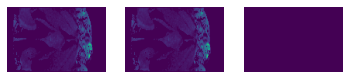

0.0 0.0
0.0 109.0


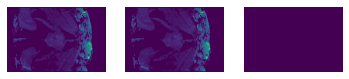

0.0 0.0
0.0 106.0


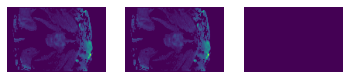

0.0 0.0
0.0 118.0


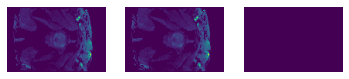

0.0 0.0
0.0 144.0


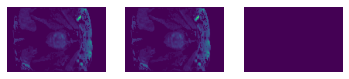

0.0 0.0
0.0 114.0


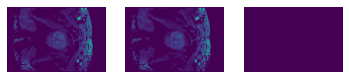

0.0 0.0
0.0 149.0


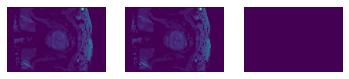

0.0 0.0
0.0 79.0


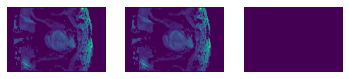

0.0 0.0
0.0 66.0


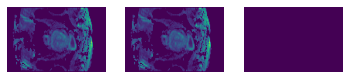

0.0 0.0
0.0 65.0


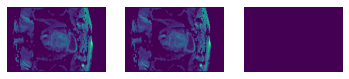

0.0 0.0
0.0 73.0


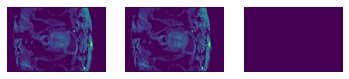

0.0 0.0
0.0 80.0


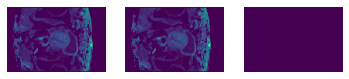

0.0 0.0
0.0 103.0


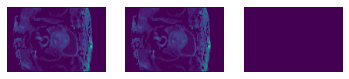

0.0 0.0
0.0 109.0


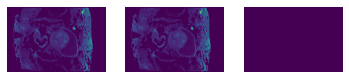

0.0 0.0
0.0 101.0


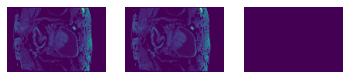

0.0 0.0
0.0 93.0


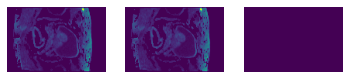

0.0 0.0
0.0 54.0


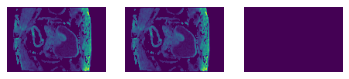

0.0 0.0
0.0 66.0


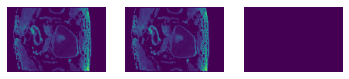

0.0 0.0
0.0 78.0


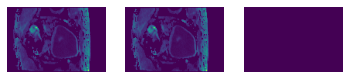

In [43]:
import matplotlib.pyplot as plt

im1 = nib.load(x).get_fdata()
im2 = nib.load(o).get_fdata()

print(im2.shape)

for i in range(im1.shape[-1]):
    D = im1[:,:,i]-im2[:,:,i]
    
    cmin = np.min([np.min(D),im1[:,:,i].min(),im2[:,:,i].min()])
    cmax = np.max([np.max(D),im1[:,:,i].max(),im2[:,:,i].max()])

    print(D.min(),D.max())
    print(np.min([im1[:,:,i],im2[:,:,i]]),np.max([im1[:,:,i],im2[:,:,i]]))
    g,ax = plt.subplots(1,3)
    ax[0].imshow(im1[:,:,i],vmin=cmin,vmax=cmax)
    ax[0].axis('off')

    ax[1].imshow(im2[:,:,i],vmin=cmin,vmax=cmax)
    ax[1].axis('off')

    ax[2].imshow(D,vmin=cmin,vmax=cmax)
    ax[2].axis('off')

    plt.show()

### Loading and aggregating gland labels

We have two types of labels in these data: gland labels and lesion labels. Any given scan could have been annotated by more than one radiologist and, for this reason, we have to aggregate labels in some manner. To do this, I have decided to simply average the labels, yielding softer labels at voxels which were labelled by a smaller proportion of radiologists as belonging to the object of interest. While there is a single gland each gland corresponds, intuitively to the one object of interest, there are multiple lesions labelled separately. This is problematic as they are not labelled in a particularly intuitive manner:

* lesion1 - lesion 1 by radiologist 1
* lesion2 - lesion 2 by radiologist 1
* lesion12 - lesion 1 by radiologist 2

Because of these considerations (retrieving average labels), I have processed them separately (using `aggregate-labels.py`) and saved them in a separate file.

### Small benchmarking of resize pipeline

After some minor tests, I have come to realise that combining MONAI I/O with TorchIO data transforms is the best solution. A caveat of this is, however, the fact that TorchIO requires all inputs in a given transform to have the same size (which may not always be the case). For this reason I unfold these transforms, i.e.:

Instead of a simple `torchio.transforms.Resize(include=t2w_keys,label_keys=t2w_keys[1:],target_shape=size_dict["T2WAx"])`, we have to combine three transforms, one for each image (original image, lesion segmentation map, prostate segmentation map). Even by doing this TorchIO still proves to be a faster solution than MONAI for these kinds of preprocessing steps.

In [44]:
import torchio

class Printd(monai.transforms.Transform):
    def __init__(self,w):
        self.w = w

    def __call__(self,X):
        print(self.w)
        return X

t2w_keys = ['T2WAx','T2WAx_gland_segmentations','T2WAx_lesion_segmentations']
dwi_keys = ['DWI','DWI_gland_segmentations','DWI_lesion_segmentations']
all_keys = t2w_keys + dwi_keys
intp = ["area","nearest","nearest"]
transforms_monai = [
    #torchio.transforms.Resample(include=t2w_keys,label_keys=t2w_keys[1:],target=spacing_dict["T2WAx"]),
    #torchio.transforms.Resample(include=dwi_keys,label_keys=dwi_keys[1:],target=spacing_dict["DWI"]),
    #torchio.transforms.Resize(include=[t2w_keys[0]],target_shape=size_dict["T2WAx"]),
    #torchio.transforms.Resize(include=[t2w_keys[1]],label_keys=[t2w_keys[1]],target_shape=size_dict["T2WAx"]),
    #torchio.transforms.Resize(include=[t2w_keys[2]],label_keys=[t2w_keys[2]],target_shape=size_dict["T2WAx"]),
    #torchio.transforms.Resize(include=[dwi_keys[0]],target_shape=size_dict["DWI"]),
    #torchio.transforms.Resize(include=[dwi_keys[1]],label_keys=[dwi_keys[1]],target_shape=size_dict["DWI"]),
    #torchio.transforms.Resize(include=[dwi_keys[2]],label_keys=[dwi_keys[2]],target_shape=size_dict["DWI"])
    ]

print(spacing_dict)
print(size_dict)

{'DWI': array([2., 2., 3.]), 'T2WAx': array([0.5, 0.5, 3. ])}
{'DWI': array([ 84, 128,  19], dtype=int32), 'T2WAx': array([384, 384,  21], dtype=int32)}


In [45]:
print(len(path_dictionary))
path_dict_list = [path_dictionary[k]
                  for k in path_dictionary
                  if all(m in path_dictionary[k] for m in all_keys)]
print(len(path_dict_list))

T = monai.transforms.Compose([
    monai.transforms.LoadImaged(all_keys),
    monai.transforms.AddChanneld(all_keys)])
d = monai.data.Dataset(path_dict_list,transform=T)

179
174


In [46]:
import time
times_1 = {
    "io":[],
    "transforms":[[] for _ in transforms_monai]}

for i in trange(len(d)):
    a = time.time()
    e = d[i]
    b = time.time()
    times_1["io"].append(b-a)

    shapes = []
    for k in e:
        try: shapes.append(e[k].shape)
        except: pass
    #print(shapes)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:52<00:00,  3.31it/s]


In [ ]:
print(np.mean(times_1["io"]),np.quantile(times_1["io"],[0,0.25,0.5,0.75,1]))

pid = "Prostatex0075"
for pid in np.random.choice(len(d),size=10):
    for K in (t2w_keys,):
        e = d[pid]
        ims = [e[k][0] for k in K]
        a,b,c = ims
        for i in np.random.choice(a.shape[-1],size=5):
            sa,sb,sc = a[:,:,i],b[:,:,i],c[:,:,i]
            print(np.quantile(sb,[0.,0.25,0.5,0.75,1.0]))
            g,ax = plt.subplots(1,3)
            ax[0].imshow(sa)
            ax[1].imshow(sb)
            ax[2].imshow(sa * np.where(sb > 0.2,1,0.5))
            plt.show()

## Slicer

Here I implement a transform that returns $N$ slices from each input provided there are sufficient positive examples in them.

In [143]:
class RandomSlices(monai.transforms.RandomizableTransform):
    def __init__(self,keys:List[str],label_key:List[str],n:int=1,base:float=0.01):
        self.keys = keys
        self.label_key = label_key
        self.n = n
        self.base = base
    
    def __call__(self,X):
        X_label = torch.Tensor(X[self.label_key])
        c = torch.flatten(X_label,start_dim=1,end_dim=-2)
        c_sum = c.sum(1)
        total_class = torch.unsqueeze(c_sum.sum(1),-1)
        c_prop = c_sum/total_class + self.base
        slice_weight = c_prop.mean(0)
        slice_idxs = torch.multinomial(slice_weight,self.n)
        return {k:torch.Tensor(np.take(X[k],slice_idxs,-1))
                for k in self.keys}
    
def collate_last_slice(X):
    def swap(x):
        return x.swapaxes(-1,0).swapaxes(-1,1).swapaxes(2,3)
    example = X[0]
    if isinstance(example,list):
        output = []
        for elements in zip(*X):
            elements = [swap(x) for x in elements]
            output.append(torch.cat(elements))
    elif isinstance(example,dict):
        keys = list(example.keys())
        output = {}
        for k in keys:
            elements = [x[k] for x in X]
            elements = [swap(x) for x in elements]
            output[k] = torch.cat(elements)
    elif isinstance(example,torch.Tensor):
        output = torch.cat([swap(x) for x in X])
    
    return output
    
rs = RandomSlices(dwi_keys,dwi_keys[1],8)
O = rs(e)
#O = [O[k] for k in O]
o = collate_last_slice((O,))

print([o[k].shape for k in o])

[torch.Size([8, 1, 84, 128]), torch.Size([8, 1, 84, 128]), torch.Size([8, 1, 84, 128])]
